# MODEL (RANDOMFOREST)
## In this notebook we will be building a random forest classifier model
*  We want use this model to beat our baseline model.
> FLOW
>>
>> Having know that our data is still imbalance despite the feature engineering, to ensure that this those not affect the performance of our model our train data will be splitted into train and validation set using ```stratifiedshufflesplit``` to ensure there are equal representation of each class to be predicted in our train and validation set.
>>
>> The train set is further augmented for class balance using the ```randomoversampler``` this is to ensure that our model is not just craming the train set and to avoid over generalization
>>
>> After this we train our model on the train set and evaluate it on the validation set using confusion matrix
>>
>> We are also interested in understanding the contribution of each features in our model
>>
> **Note this workflow is applicable to all the other models**

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import RandomOverSampler 
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler

plt.style.use("seaborn-dark")

In [2]:
# Defining the path to train, test data
test_pth = "test_Wf7sxXF.csv"
train_pth = "train_wn75k28.csv"

In [3]:
# Wrangling our data, this process is derived from the feature engineering section

def wrangling(path):
    df = pd.read_csv(path, index_col='id')
    
    # Removing missing values for products_purchased and signup_date for products not purchased
    product_not_bought = df[df["buy"] == 0]
    product_not_bought_purchased_isna = product_not_bought[product_not_bought["products_purchased"].isna()]
    index_purchased_isna = product_not_bought_purchased_isna.index
    df.drop(index = index_purchased_isna, inplace=True)
    
    product_not_bought = df[df["buy"] == 0]
    product_not_bought_signup_date= product_not_bought[product_not_bought["signup_date"].isna()]
    index_signup_date_isna = product_not_bought_signup_date.index
    df.drop(index = index_signup_date_isna, inplace=True)
    
    # Summing all the user activity
    user_activity_col = [x for x in df.columns if x.startswith("user")]
    df["sum_user_activities"] = np.sum([df[x] for x in user_activity_col], 0)
    
    # Making the date columns usable for our model
    df["created_at"] = pd.to_datetime(df["created_at"], format="%Y-%m-%d")
    df["signup_date"] = pd.to_datetime(df["signup_date"], format="%Y-%m-%d")
    day = df["created_at"] - df["signup_date"]
    day = day.replace({np.nan:day.max()})
    day = day.astype('str').str.split(" ", expand=True)[0]
    day["day"] = np.abs(day.astype('int'))
    
    # Summing the campaign vars in the data
    camp_col = [x for x in df.columns if x.startswith("camp")]
    df["sum_camp"] = np.sum([df[x] for x in camp_col], 0)
    
    # imputting missing value
    df["products_purchased"] = df["products_purchased"].fillna(0)
    
    # Removing unwanted columns
    df.drop(columns = camp_col + ["created_at", "signup_date"] + user_activity_col, inplace=True)
    return df

In [4]:
# Loading our train data into our notebook
df = wrangling(train_pth)

In [5]:
# Define the feature and label for our data using X and y respectively
X = df.drop(columns="buy")
y = df["buy"]

In [6]:
# Splitting our data into train and validation set, with 80% used for training and 20% for validation
sss = StratifiedShuffleSplit(n_splits= 100, test_size=0.2, random_state=234)
for train_index, val_index in sss.split(X, y):
    X_train, y_train = X.copy().iloc[train_index], y.copy().iloc[train_index]
    X_val, y_val = X.copy().iloc[val_index], y.copy().iloc[val_index]

### DEALING WITH IMBALANCE
* As it has been pointed out earlier that our data is imbalance we train and up scale the class with less count which in the case is class 1 and the approach taken is to scale the train set to 10,000 from 1598

In [7]:
print("Initial state of class before augmenting\n", y_train.value_counts(), end="\n\n") # Checking the class count of train set before augmentation

resampler = RandomOverSampler(sampling_strategy={0:10762, 1:10000}, random_state=234)
X_res, y_res = resampler.fit_resample(X_train, y_train)

print("Final state of class after augmenting\n", y_res.value_counts()) # Checking the class count of train set before augmentation

Initial state of class before augmenting
 0    10762
1     1598
Name: buy, dtype: int64

Final state of class after augmenting
 0    10762
1    10000
Name: buy, dtype: int64


### BUILDING MODEL
* In building the model the following will be considered
1. Imputting missing values
2. Because of the high range between our data we are going to be standardizing it
3. Finally we will define our logistic regression model
* All this phase will be put to gather using a pipeline to afford redundancy and reuseability

In [8]:
# Defining our model
rf_model = Pipeline([("simpleimputer", SimpleImputer()), 
                      ("standardscaler", StandardScaler()), 
                      ("randomforestclassifier", RandomForestClassifier(class_weight="balanced", random_state=123))
                     ])

# fitting our data to the model
rf_model.fit(X_res, y_res)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=123))])

### MODEL EVALUATION
* The model is evaluated using precision, recall, f1 score and accuracy which is as display below
* The model is evaluation not only on the validation set but also on the train set this is to check that our model is not overfitting
* Also, the performance of our model can also be visualized as shown below

In [9]:
# Evaluating on the validation set
print(classification_report(y_val, rf_model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.97      0.89      0.92      2691
           1       0.51      0.79      0.62       400

    accuracy                           0.87      3091
   macro avg       0.74      0.84      0.77      3091
weighted avg       0.91      0.87      0.88      3091



In [10]:
# Evaluating on the train set
print(classification_report(y_train, rf_model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93     10762
           1       0.53      0.80      0.63      1598

    accuracy                           0.88     12360
   macro avg       0.75      0.85      0.78     12360
weighted avg       0.91      0.88      0.89     12360



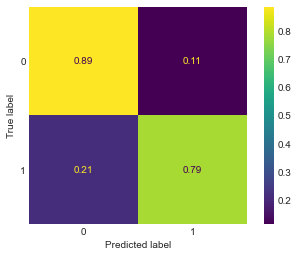

In [11]:
# Inpecting the perfomance of our model using confusion matrix
ConfusionMatrixDisplay.from_estimator(rf_model, X_val, y_val, normalize="true");

### FEATURE IMPORTANCE
* Using the coffient of our model we can have an understanding of the contribution of the each feature to the performance of the model
* from the table below we can judge that the user_activities greatly contribute to whether a product will be bought or not

In [12]:
# Extracting the coeffient of our model
coeffient = rf_model.named_steps["randomforestclassifier"].feature_importances_ 
feature_importance = pd.DataFrame({"importance":coeffient[0], "feature":X.columns})[["feature", "importance"]]
feature_importance.style.background_gradient(axis=0)

,feature,importance
0,products_purchased,0.555858
1,sum_user_activities,0.555858
2,sum_camp,0.555858


### RUNNING PREDICTION ON AN UNKNOWN DATA
* We use our model to predict a new data
* We are going to wraggle our new data to get it to the stage of it been accepted by our model else it will thrown error at our face
* Then we run a prediction on the model
* Our prediction will be output as a CSV file which can be shared with our stakeholders

In [13]:
# Wrangling function for our test data which is an extract of the wrangling for the train data
def wrangling_test(path):
    df = pd.read_csv(path, index_col='id')
    
    # Summing all the user activity
    user_activity_col = [x for x in df.columns if x.startswith("user")]
    df["sum_user_activities"] = np.sum([df[x] for x in user_activity_col], 0)
    
    # Making the date columns usable for our model
    df["created_at"] = pd.to_datetime(df["created_at"], format="%Y-%m-%d")
    df["signup_date"] = pd.to_datetime(df["signup_date"], format="%Y-%m-%d")
    day = df["created_at"] - df["signup_date"]
    day = day.replace({np.nan:day.max()})
    day = day.astype('str').str.split(" ", expand=True)[0]
    day["day"] = np.abs(day.astype('int'))
    
    # Summing the campaign vars in the data
    camp_col = [x for x in df.columns if x.startswith("camp")]
    df["sum_camp"] = np.sum([df[x] for x in camp_col], 0)
    
    # imputting missing value
    df["products_purchased"] = df["products_purchased"].fillna(0)
    
    # Removing unwanted columns
    df.drop(columns = camp_col + ["created_at", "signup_date"] + user_activity_col, inplace=True)
    return df

In [14]:
# Applying the wrangling function to our test data
X_test = wrangling_test(test_pth)
X_test.head() # Previewing our data after wrangling

,products_purchased,sum_user_activities,sum_camp
id,,,
39162,0.0,4,4
39163,3.0,2,11
39164,0.0,2,15
39165,2.0,5,17
39166,2.0,1,9


In [15]:
# predicting the class label for our test data
test_pred = rf_model.predict(X_test)

In [16]:
# Storing our test_pred in a dataframe
test_pred_df = pd.DataFrame({"buy":test_pred, "id":X_test.index}).set_index("id")
test_pred_df.sample(5)

,buy
id,
44489,1
41113,0
48036,1
45610,0
40214,0


In [17]:
# Extracting our model name from the model using regex
import re # importing regex

# Model name extractor and stored using the variable name model_name
model_name = (re.match("[A-Za-z]*", str(rf_model.named_steps["randomforestclassifier"].__class__)
              .split(".")[-1])
              .group(0)
             )
print("model name:", model_name)

model name: RandomForestClassifier


In [18]:
# Exporting our predicted labels to csv
test_pred_df.to_csv(model_name + "_model.csv")